In [503]:
### Imports ###
import os
import numpy as np
import pandas as pd 
import matplotlib

In [504]:
NAMES_PAULI = ["qs", "depth", "tcount", "red_tcount","min_weight","max_weight","seed","terms","time","alpha"]
NAMES_IQP = ["qs", "tcount", "red_tcount","seed","terms","time","alpha"]
NAMES_HS = ["qs", "depth", "seed", "terms", "time", "tcount", "alpha"]
NAMES_CCZ = ["qs", "depth", "tcount", "red_tcount", "seed", "terms", "time", "alpha"]
NAMES = NAMES_HS
# NAMES = ["qs", "depth", "tcount", "min_weight", 
#                "max_weight", "nsamples", "seed", "terms", 
#                "time", "tcounts", "no_simp", "naive", "alpha"]
groupby_data = "tcount"
# groupby_data = "initial_tcount"
# groupby_data = "red_tcount"
# groupby_data = "qs"
# efficiency = "beta"
efficiency = "alpha"
TIMEOUT = 90 * 1000
QS = None
QS_TPL = (7, 19, 47, 97)

In [505]:
### Collect Simulation Data ###
dfs = []
# data_folder = "data_iqp_heur_0723"
# data_folder = "data_heur_full_0724"
# data_folder = "data_heur_pair_full_0806"
# data_folder = "data_cutpg_full_0803"
# data_folder = "data_cat4_pair_0802"
data_folder = "data_hs_heur_pair_full_0805"
# data_folder = "data"
# data_folder = "data_iqp"
# data_folder = "data_hs_nocomp_0805"
feat_name = "heur"
for f in os.listdir(data_folder):
    # if "100_70_2_4_1_4842" in f: continue
    curr = pd.read_csv(
        f"{data_folder}/{f}", 
        header=None, 
        names=NAMES
    )    
    curr.loc[0, feat_name] = True
    dfs.append(curr)
    

# og_data_folder = "data"
og_data_folder = "data_hs_og_full_0805"
# og_data_folder = "data_ccz_og_0805"
# og_data_folder = "data_iqp_og_0723"
# og_data_folder = "data_iqp_heur_0723"
# og_data_folder = "data_heur_full_0724"
# og_data_folder = "data_og_full_0804"
# og_data_folder = "data_cut_cat4_0802"
for f in os.listdir(og_data_folder):
    curr = pd.read_csv(
        f"{og_data_folder}/{f}", 
        header=None, 
        names=NAMES
    )
    curr.loc[0, feat_name] = False
    dfs.append(curr)

# data_folder3 = "data_iqp_cat3_0723"
# data_folder3 = "data_cat3_full_0723"
# data_folder3 = "data_heur_full_0724"
# data_folder3 = "data_hs_heur_single_full_0805
# data_folder3 = "data"
# for f in os.listdir(data_folder3):
#     curr = pd.read_csv(
#         f"{data_folder3}/{f}", 
#         header=None, 
#         names=NAMES
#     )
#     curr.loc[0, feat_name] = 2
#     dfs.append(curr)

full_data = pd.concat(dfs, ignore_index=True)



# full_data["max_tcount"] = full_data["tcounts"].str.split(",")
# if full_data["alpha"].dtype != np.float64:
#     full_data["alpha"] = full_data["alpha"].str.split(",")
#     # full_data = full_data.explode(["max_tcount", "alpha"])
#     # print(len(full_data["alpha"][100]))
#     full_data["alpha"] = full_data["alpha"].apply(lambda x: x[int(len(x)*0.9)])
#     full_data["max_tcount"] = full_data["max_tcount"].apply(lambda x: x[int(len(x)*0.9)])

#     # full_data["argmax"] = full_data["alpha"].apply(lambda x: np.argmax([float(i) for i in x]))
#     # full_data["alpha"] = full_data.apply(lambda x: x["alpha"][x["argmax"]], axis=1)
#     # full_data["max_tcount"] = full_data.apply(lambda x: x["max_tcount"][x["argmax"]], axis=1)
# else:
#     full_data = full_data.explode("max_tcount")

# full_data = full_data.astype({"max_tcount": int, "alpha": float})

# # full_data["max_tcount"] = full_data["max_tcount"].apply(lambda x: max(x, 1))
# full_data = full_data[full_data["max_tcount"] > 0]


def parse_tcounts_max(tcounts):
    return max(max(map(int, tcounts.split(","))), 1)

def parse_alphas_tcounts(alphas, tcounts):
    if "," not in alphas:
        return float(alphas), parse_tcounts_max(tcounts)
    alpha_t = list(zip([int(x) for x in alphas.split(",")], [int(x) for x in tcounts.split(",")]))
    return max(alpha_t, key=lambda x: x[0])

if QS is not None:
    full_data = full_data[full_data["qs"] == QS]
if "red_tcount" not in full_data.columns:
    full_data["initial_tcount"] = full_data["depth"] * 14

full_data = full_data[full_data['time'] <= 1 * TIMEOUT]
if "red_tcount" not in NAMES:
full_data = full_data[full_data['qs'] != 10]
full_data = full_data[full_data['qs'] != 8]
# Apply the function to the column and create a new column
# full_data['max_tcount'] = full_data['tcounts'].apply(parse_tcounts_max)
# print(full_data["sum_tcounts"].dtype)
# full_data["alpha"] = np.log2(full_data["terms"]) / full_data['initial_tcount']
# full_data = full_data[full_data['time'] >= 500]
# convert milliseconds -> seconds
# full_data["time"] /= 1sdsd
full_data["log_terms"] = np.log2(full_data["terms"])
full_data["log_time"] = np.log2(full_data["time"])
full_data["beta"] = full_data["log_terms"] / full_data["qs"]

undropped_data = full_data.copy()

full_data = full_data[full_data['alpha'] >= 0]
full_data = full_data.dropna(subset=['log_terms', 'log_time'])

# full_data = full_data[full_data["depth"] < 10]

# full_data["log_terms"] = full_data["log_terms"].clip(lower=0)
# full_data["log_time"] = full_data["log_time"].clip(lower=0)

if groupby_data != "qs":
    full_data = full_data[full_data[groupby_data] > 15]
    full_data = full_data[full_data[groupby_data] < 100]
# full_data = full_data[full_data['alpha'] >= 0.2]

data = full_data.copy()

if "min_weight" in full_data.columns:
    # full_data = full_data[full_data["tcount"] < 110]
    data = full_data.drop(["min_weight", "max_weight"], axis=1)

data.head()

/Users/wira/miniconda3/envs/quantum/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qs,depth,seed,terms,time,tcount,alpha,heur,initial_tcount,log_terms,log_time,beta
2,20,3,6169,4,2,24,0.083333,True,42,2.000000,1.000000,0.100000
4,20,4,7866,16,7,36,0.111111,True,56,4.000000,2.807355,0.200000
5,20,3,7887,6,3,24,0.107707,True,42,2.584963,1.584963,0.129248
6,50,5,8196,8,7,40,0.075000,True,70,3.000000,2.807355,0.060000
7,20,10,199,76,101,112,0.055785,True,140,6.247928,6.658211,0.312396


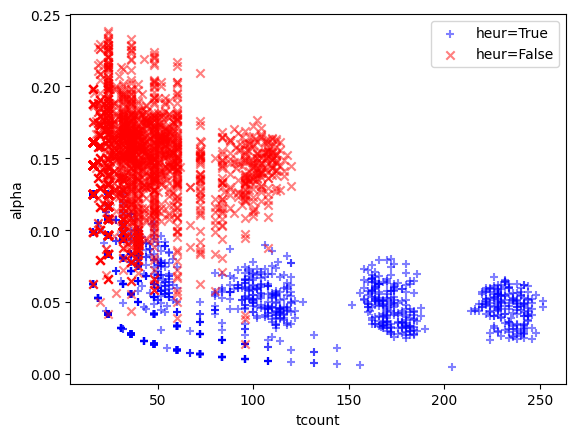

In [506]:
import matplotlib.pyplot as plt

# Filter the data for bcc=True and bcc=False
data_bcc_true = data[data[feat_name] == True]
data_bcc_false = data[data[feat_name] == False]
data_bcc_2 = data[data[feat_name] == 2]

# Plot the data with translucent points
plt.scatter(data_bcc_true[groupby_data], data_bcc_true['alpha'], color='blue', label=f'{feat_name}=True', alpha=0.5, marker='+')
plt.scatter(data_bcc_false[groupby_data], data_bcc_false['alpha'], color='red', label=f'{feat_name}=False', alpha=0.5, marker='x')
# plt.scatter(data_bcc_2[groupby_data], data_bcc_2['alpha'], color='green', label=f'{feat_name}=heur', alpha=0.5, marker='o', facecolors='none')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel('alpha')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [507]:
### Comparison at each size ###
# groupby_data = "max_tcount"
# feat_name = "min_uncut"
data.groupby([groupby_data,feat_name]).agg(
    avg_time=pd.NamedAgg("time", "mean"),
    std_time=pd.NamedAgg("time", np.std),
    med_time=pd.NamedAgg("time", "median"),
    avg_a=pd.NamedAgg("alpha", "mean"),
    std_a=pd.NamedAgg("alpha", np.std),
    med_a=pd.NamedAgg("alpha", "median"),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_76238/1834889147.py:4: FutureWarning: The provided callable <function std at 0x105cacea0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data.groupby([groupby_data,feat_name]).agg(


avg_time      std_time  med_time     avg_a     std_a  \
tcount heur                                                              
16     False      1.699571      0.728040       2.0  0.145622  0.022984   
       True       1.828283      1.646657       2.0  0.117532  0.019845   
17     False      3.500000      0.707107       3.5  0.190937  0.006322   
18     False      3.000000      1.000000       3.0  0.162128  0.016718   
19     False     14.176471     11.922656      12.0  0.158539  0.028711   
...                    ...           ...       ...       ...       ...   
242    True   15563.052632  23598.701333    4433.0  0.040560  0.011206   
244    True   24585.000000  26006.768696   11419.0  0.046162  0.008022   
246    True   17401.833333  14762.802897   16314.5  0.040625  0.010752   
248    True   31620.000000  42430.649512   31620.0  0.041703  0.018381   
252    True   26560.500000  27794.246248   26560.5  0.048778  0.003288   

                 med_a  
tcount heur             
16     False  0.145121  
       True   0.125000  
17     False  0.190937  
18     False  0.166667  
19     False  0.152825  
...                ...  
242    True   0.039983  
244    True   0.043544  
246    True   0.043045  
248    True   0.041703  
252    True   0.048778  

[167 rows x 6 columns]

<Axes: xlabel='Number of qubits, T-count', ylabel='Mean Log Time'>

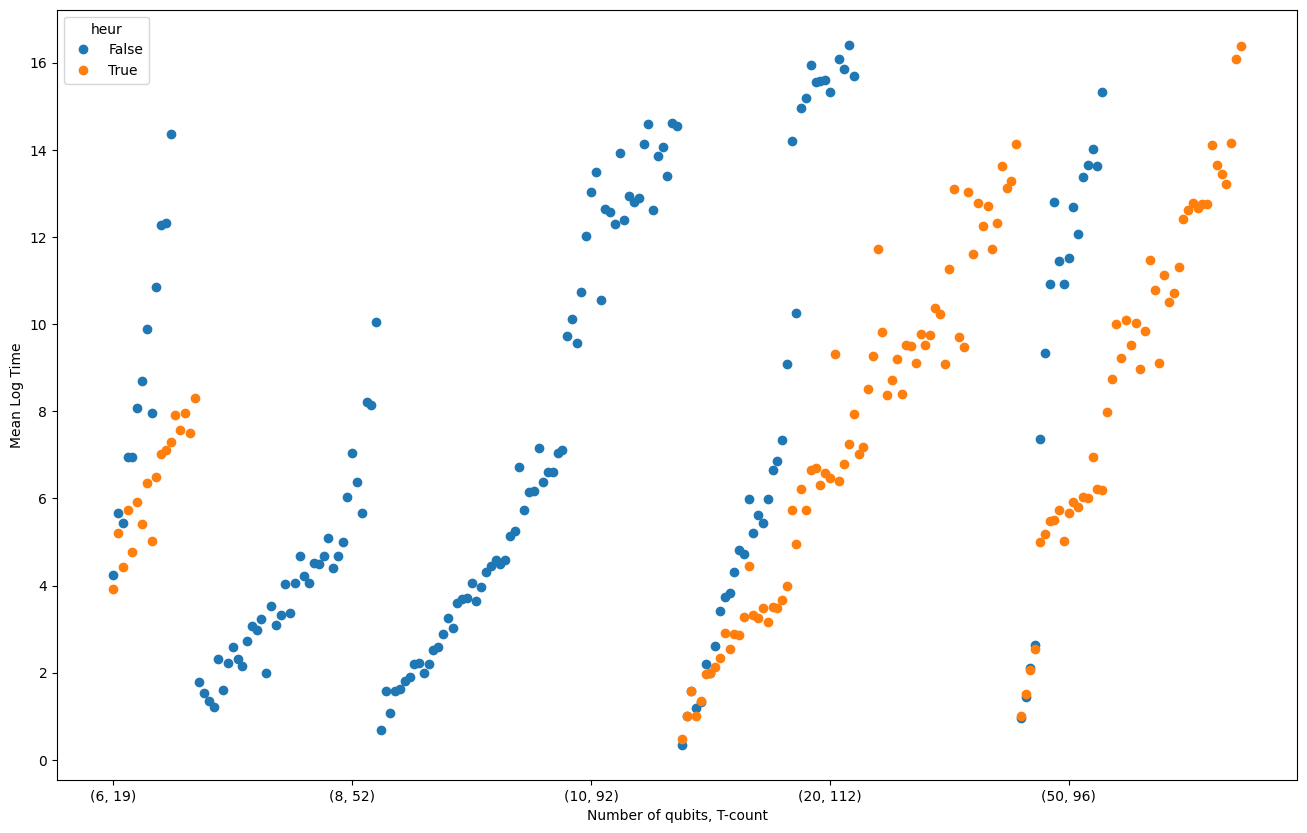

In [508]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby(["qs", groupby_data,feat_name]).mean().unstack()["log_time"].plot(
    xlabel="Number of qubits, T-count", 
    ylabel="Mean Log Time",
    marker="o",
    linestyle="None",
    figsize=(16,10)
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_76238/385706317.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_time"])


   qs  depth  seed  terms  time  tcount     alpha  heur  initial_tcount  \
2  20      3  6169      4     2      24  0.083333  True              42   
4  20      4  7866     16     7      36  0.111111  True              56   
5  20      3  7887      6     3      24  0.107707  True              42   
6  50      5  8196      8     7      40  0.075000  True              70   
7  20     10   199     76   101     112  0.055785  True             140   

   log_terms  log_time      beta  
2   2.000000  1.000000  0.100000  
4   4.000000  2.807355  0.200000  
5   2.584963  1.584963  0.129248  
6   3.000000  2.807355  0.060000  
7   6.247928  6.658211  0.312396  
      qs  depth  seed  terms  time  tcount     alpha   heur  initial_tcount  \
3377  20      3  6169      9     3      24  0.132080  False              42   
3378   8      3  1299     34     6      30  0.169582  False              42   
3380  20      4  7866     39     9      36  0.146817  False              56   
3381  20      3  7887  

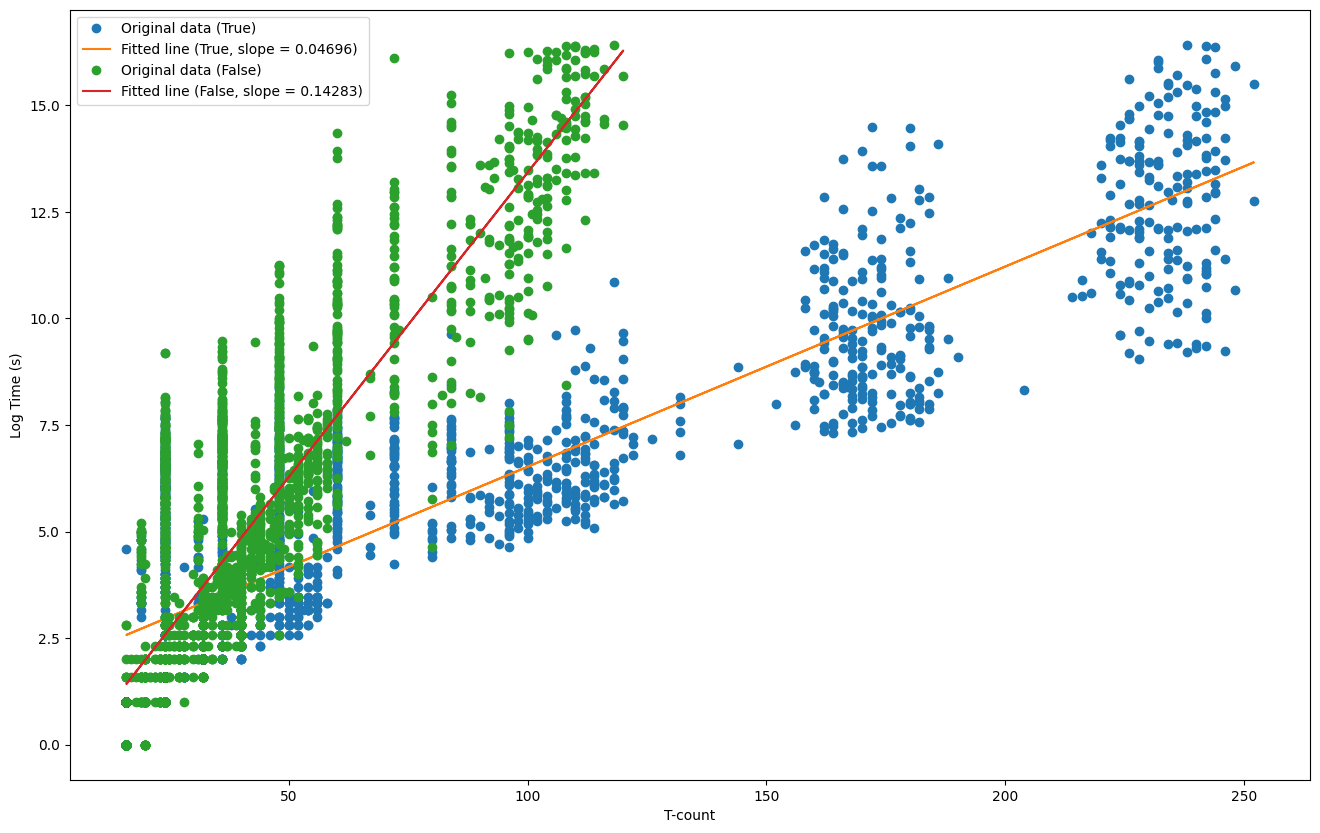

In [509]:
import numpy as np
import matplotlib.pyplot as plt

# Drop NaN values from the data
grouped_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_time"])


# Get unique feat_name values
unique_feats = grouped_data[feat_name].unique()

# Plot each line for each feat_name value
plt.figure(figsize=(16, 10))

for feat in unique_feats:
    # Filter data for the current feat_name
    feat_data = grouped_data[grouped_data[feat_name] == feat]
    print(feat_data.head())
    
    # Extract x and y values for the current feat_name
    x = feat_data[groupby_data].values
    y = feat_data["log_time"].values

    # Fit a line to the data
    slope, intercept = np.polyfit(x, y, 1)

    # Plot the data and the fitted line
    plt.plot(x, y, 'o', label=f'Original data ({feat})')
    plt.plot(x, slope * x + intercept, label=f'Fitted line ({feat}, slope = {slope:.5f})')

# Add labels and legend
plt.xlabel("T-count")
plt.ylabel("Log Time (s)")
plt.legend()
plt.show()

In [510]:
grouped_data

,qs,depth,seed,terms,time,tcount,alpha,heur,initial_tcount,log_terms,log_time,beta
2,20,3,6169,4,2,24,0.083333,True,42,2.000000,1.000000,0.100000
4,20,4,7866,16,7,36,0.111111,True,56,4.000000,2.807355,0.200000
5,20,3,7887,6,3,24,0.107707,True,42,2.584963,1.584963,0.129248
6,50,5,8196,8,7,40,0.075000,True,70,3.000000,2.807355,0.060000
7,20,10,199,76,101,112,0.055785,True,140,6.247928,6.658211,0.312396
...,...,...,...,...,...,...,...,...,...,...,...,...
7341,10,5,4826,420,111,54,0.161375,False,70,8.714246,6.794416,0.871425
7345,6,15,6811,5,11,19,0.122207,False,210,2.321928,3.459432,0.386988
7347,50,4,1582,15,6,32,0.122090,False,56,3.906891,2.584963,0.078138
7348,50,2,7712,5,2,16,0.145121,False,28,2.321928,1.000000,0.046439


<Axes: xlabel='T-count', ylabel='Mean alpha'>

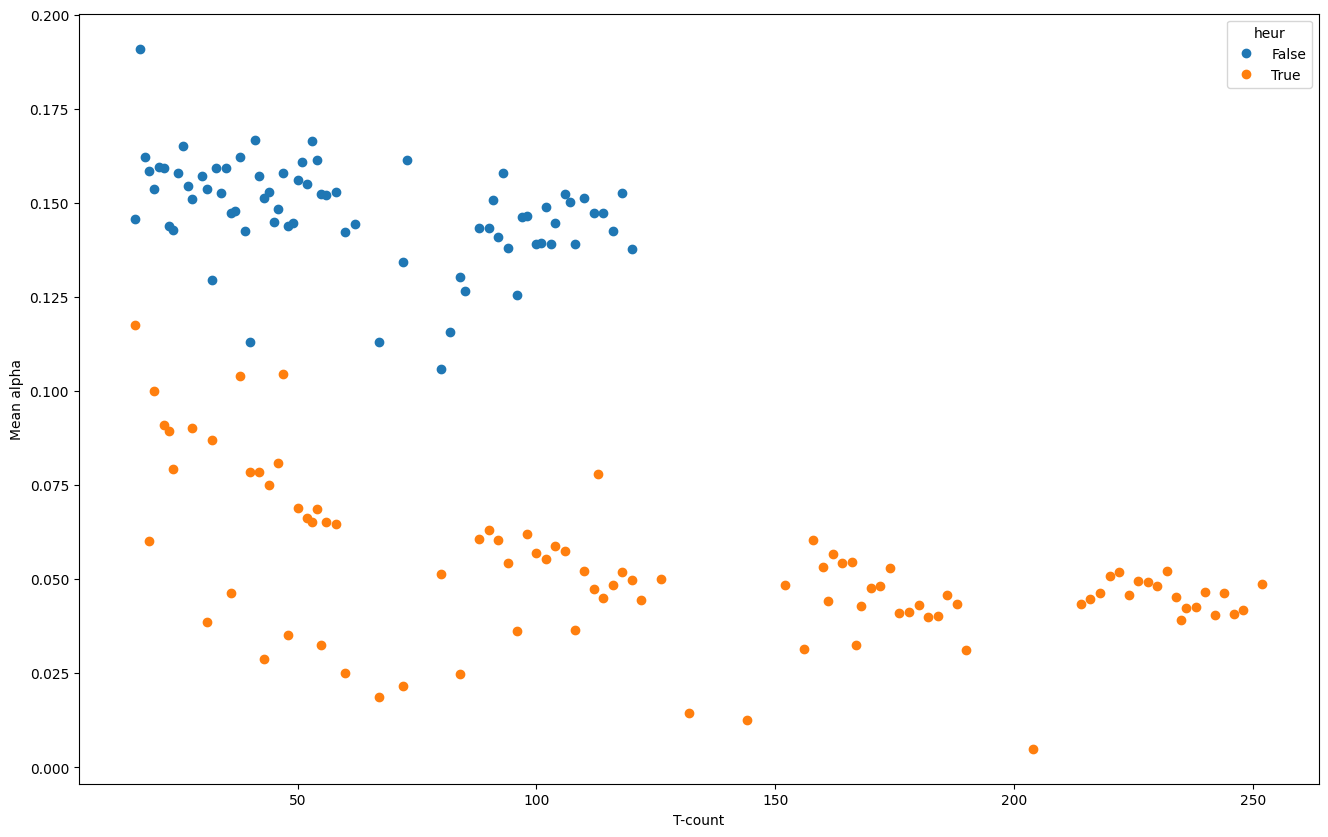

In [511]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Mean alpha",
    marker="o",
    linestyle="None",
    figsize=(16,10)
)

qs  tcount  heur 
6   19      False     4.231076
            True      3.919698
    24      False     5.655522
            True      5.210279
    31      False     5.436501
                       ...    
50  236     True     13.439991
    238     True     13.219395
    240     True     14.157113
    242     True     16.084414
    244     True     16.377821
Name: log_time, Length: 304, dtype: float64


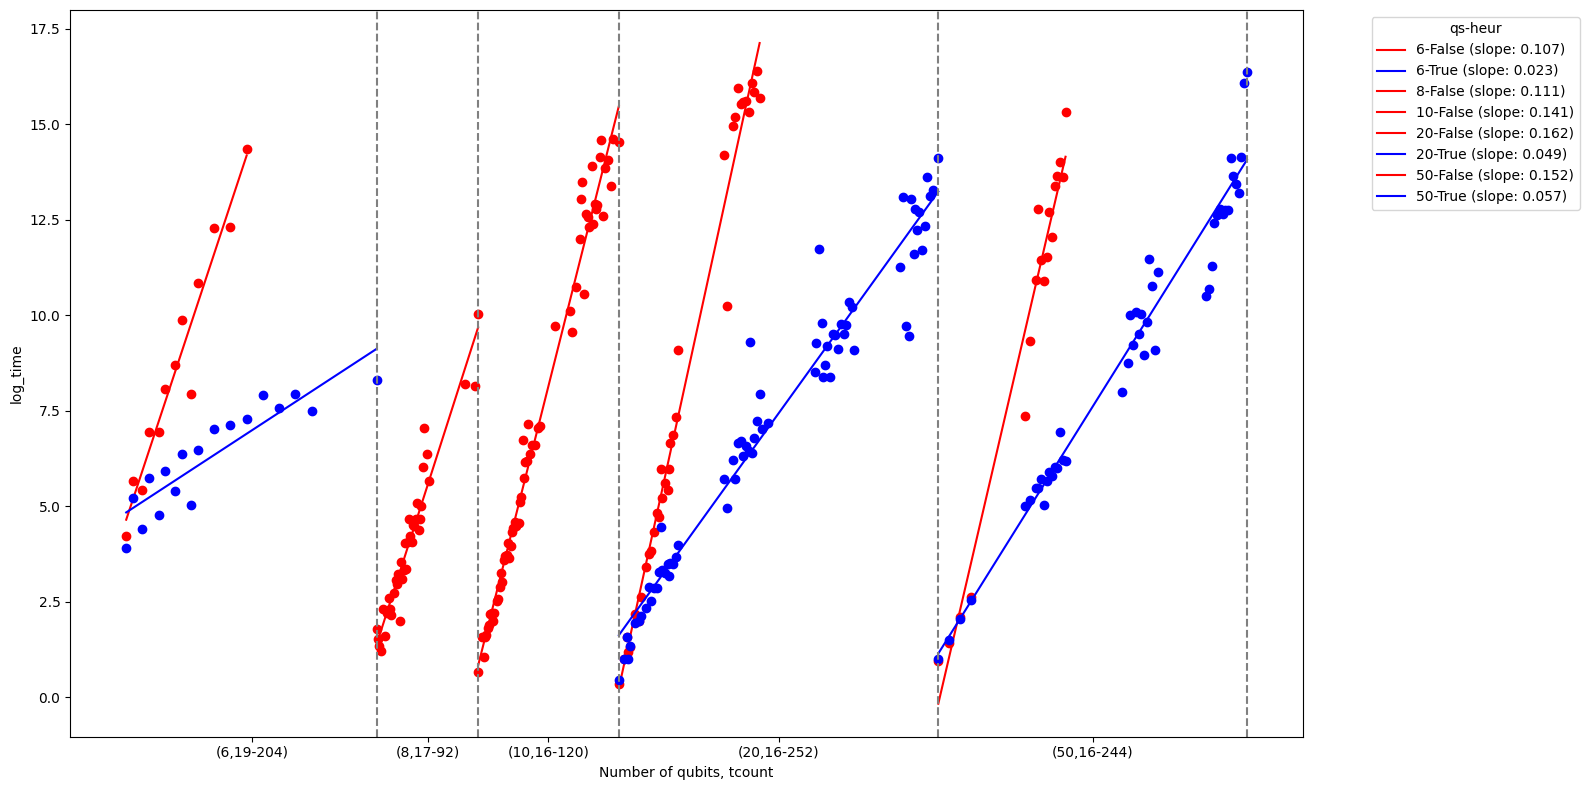

In [512]:
import numpy as np
import matplotlib.pyplot as plt

metric = "log_time"

# Assuming 'data' is your DataFrame and 'groupby_data' and 'feat_name' are your column names
if groupby_data != "qs":
    grouped_data = data.groupby(["qs", groupby_data, feat_name])
    # Calculate mean
    mean_data = grouped_data.mean()[metric]
else:
    mean_data = data.reset_index().set_index([groupby_data, feat_name])[metric]

# print(grouped_data.agg()[metric])

print(mean_data)


# print(mean_data.index.names)


# Ensure mean_data has a MultiIndex
if not isinstance(mean_data.index, pd.MultiIndex):
    raise TypeError("Index must be a MultiIndex")

# Print the unique values for each level of the MultiIndex
# print("Unique values for 'qs':", mean_data.index.get_level_values('qs').unique())
# print(f"Unique values for '{feat_name}':", mean_data.index.get_level_values(feat_name).unique())

# Plot with error bars
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the mean data for each pair (qs, feat_name)
if groupby_data != "qs":
    qs_values = mean_data.index.get_level_values('qs').unique()
else:
    qs_values = []
feat_names = mean_data.index.get_level_values(feat_name).unique()


cur_index = 0

num_values_list = []


for i in range(len(qs_values)):
    qs = qs_values[i]
    num_values = 0
    min_value = np.inf
    max_value = 0
    for feat in feat_names:
        try:
            mean_data_pair = mean_data.xs((qs, feat), level=('qs', feat_name))        
        except KeyError:
            print(qs, feat)
            # Handle cases where the combination of qs and feat_name does not exist
            continue

        
        # drop inf values
        mean_data_pair = mean_data_pair.replace([np.inf, -np.inf], np.nan).dropna()
        if mean_data_pair.empty:
            continue

        groupby_data_values = sorted(mean_data_pair.index.get_level_values(groupby_data).unique())
        num_values = max(num_values, len(groupby_data_values))
        min_value = min(min_value, min(groupby_data_values))
        max_value = max(max_value, max(groupby_data_values))    

        x_values = [cur_index + x - min(groupby_data_values) for x in groupby_data_values]
        y_values = mean_data_pair.values.flatten()

        # print(x_values)
        # print(y_values)
        color = 'blue' if feat else 'red'

        ax.plot(
            x_values,
            y_values,
            marker="o",
            linestyle="None",
            color=color
        )

        # Fit a linear regression model to find the slope for each pair (qs, feat_name)
        x = np.array(groupby_data_values)
        y = mean_data_pair.values.flatten()
        slope, intercept = np.polyfit(x, y, 1)

        # print(type(x[0]))

        if np.isnan(slope):
            print(f"Slope is NaN for qs: {qs}, feat: {feat}")
            print(mean_data_pair)
        
        
        # Plot the linear regression line
        ax.plot(x_values, slope * x + intercept, linestyle='-', label=f'{qs}-{feat} (slope: {slope:.3f})', color=color)



    num_values_list.append((qs,  min_value, max_value))
    cur_index += max_value - min_value

cur_index = 0

tick_positions = []
tick_labels = []

for (qs, min_value, max_value) in num_values_list:
    range_value = max_value - min_value
    cur_index += range_value
    ax.axvline(x=cur_index, color='gray', linestyle='--')
    tick_positions.append(cur_index - range_value // 2)
    tick_labels.append(f'({qs},{min_value}-{max_value})')
   

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

plt.ylabel(metric)
plt.xlabel(f'Number of qubits, {groupby_data}')

plt.legend(title=f'qs-{feat_name}', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

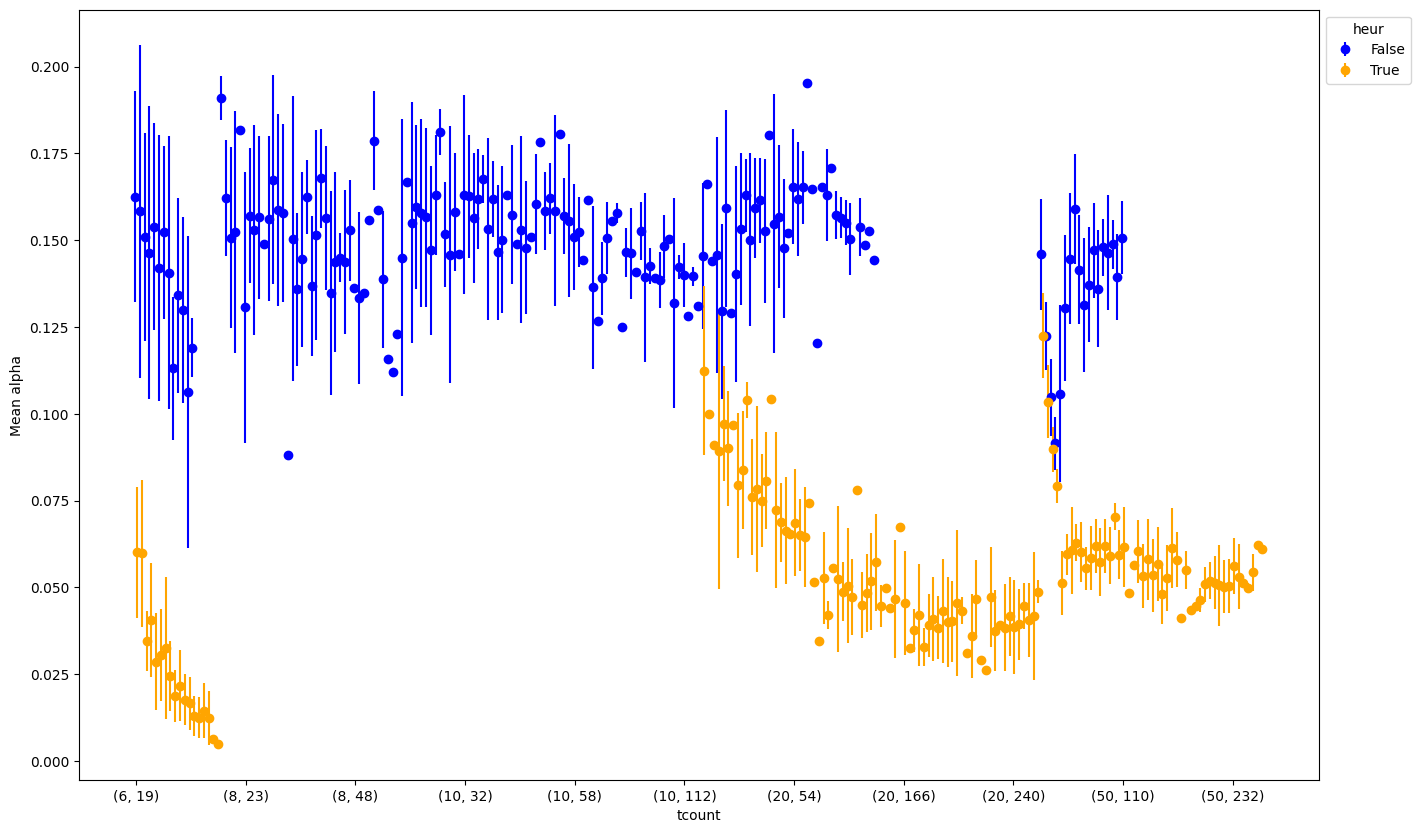

In [513]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Assuming 'data' is your DataFrame and 'groupby_data' and 'feat_name' are your column names
if groupby_data != "qs":
    efficiency = "alpha"
    grouped_data = data.groupby(["qs",groupby_data, feat_name])
else:
    efficiency = "beta"
    grouped_data = data.groupby([groupby_data, feat_name])

# Calculate mean and standard deviation
mean_data = grouped_data.mean().unstack()[efficiency]
std_data = grouped_data.std().unstack()[efficiency]

# Plot with error bars
fig, ax = plt.subplots(figsize=(16, 10))

# Number of groups
n_groups = len(mean_data.columns)

# Width of each bar
bar_width = 0.8 / n_groups

# Positions of the bars
indices = np.arange(len(mean_data))

for i, (col, color) in enumerate(zip(mean_data.columns, ['blue', 'orange', 'green', 'red'])):
    ax.errorbar(
        indices + i * bar_width,
        mean_data[col],
        yerr=std_data[col],
        fmt='o',
        label=col,
        color=color,
        linestyle='None'
    )

ax.set_xlabel(f"{groupby_data}")
ax.set_ylabel(f"Mean {efficiency}")
# Reduce the number of x-ticks
step = max(1, len(mean_data) // 10)  # Show at most 10 x-ticks
ax.set_xticks(indices[::step] + bar_width * (n_groups - 1) / 2)
ax.set_xticklabels(mean_data.index[::step])
ax.legend(title=feat_name, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

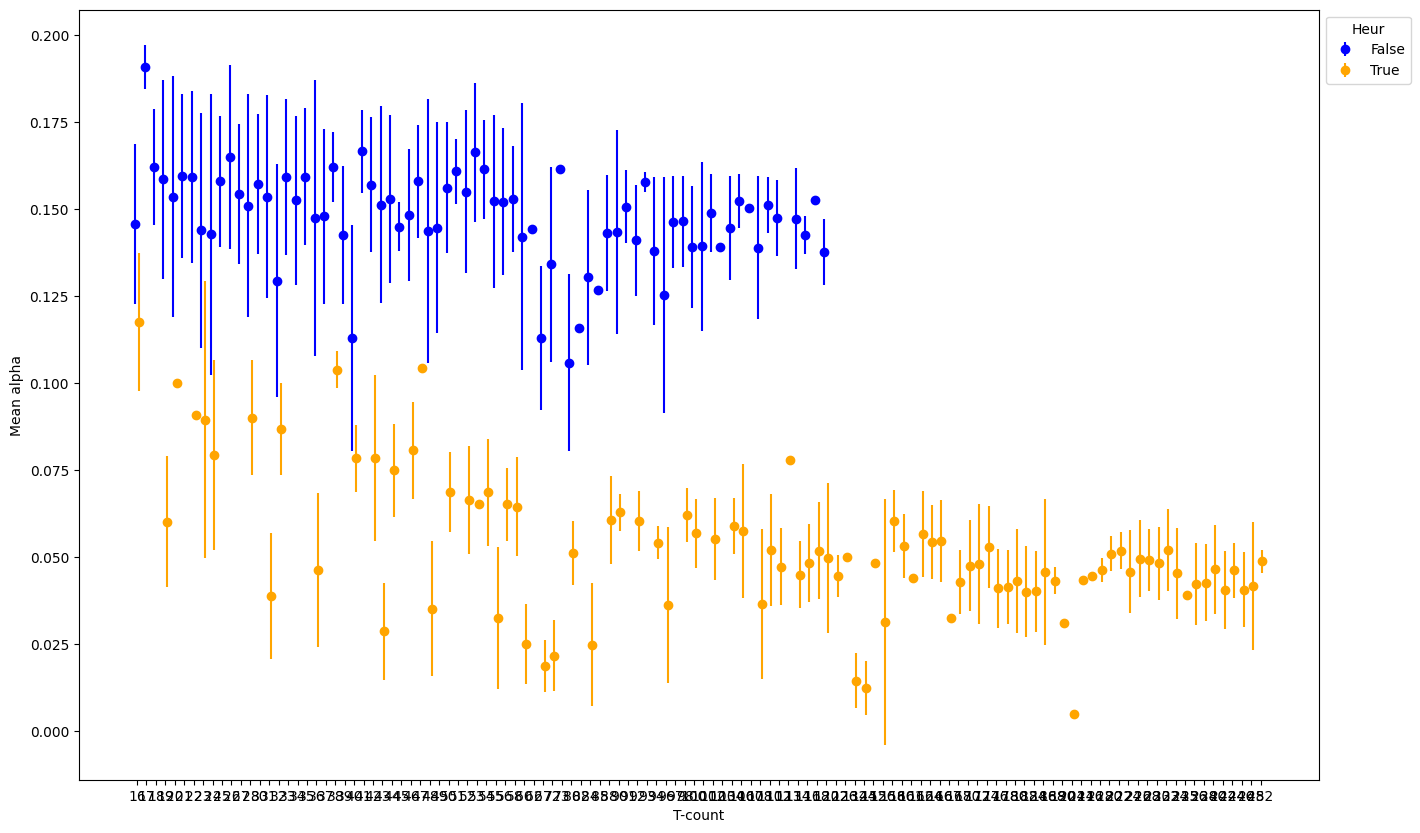

In [514]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric = "alpha"

# Assuming 'data' is your DataFrame and 'groupby_data' and 'feat_name' are your column names
grouped_data = data.groupby([groupby_data, feat_name])

# Calculate mean and standard deviation
mean_data = grouped_data.mean().unstack()[metric]
std_data = grouped_data.std().unstack()[metric]

# Plot with error bars
fig, ax = plt.subplots(figsize=(16, 10))

# Number of groups
n_groups = len(mean_data.columns)

# Width of each bar
bar_width = 0.8 / n_groups

# Positions of the bars
indices = np.arange(len(mean_data))

for i, (col, color) in enumerate(zip(mean_data.columns, ['blue', 'orange', 'green', 'red'])):
    ax.errorbar(
        indices + i * bar_width,
        mean_data[col],
        yerr=std_data[col],
        fmt='o',
        label=col,
        color=color,
        linestyle='None'
    )

ax.set_xlabel("T-count")
ax.set_ylabel(f"Mean {metric}")
ax.set_xticks(indices + bar_width * (n_groups - 1) / 2)
ax.set_xticklabels(mean_data.index)
ax.legend(title='Heur', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

<Axes: xlabel='T-count', ylabel='Mean alpha'>

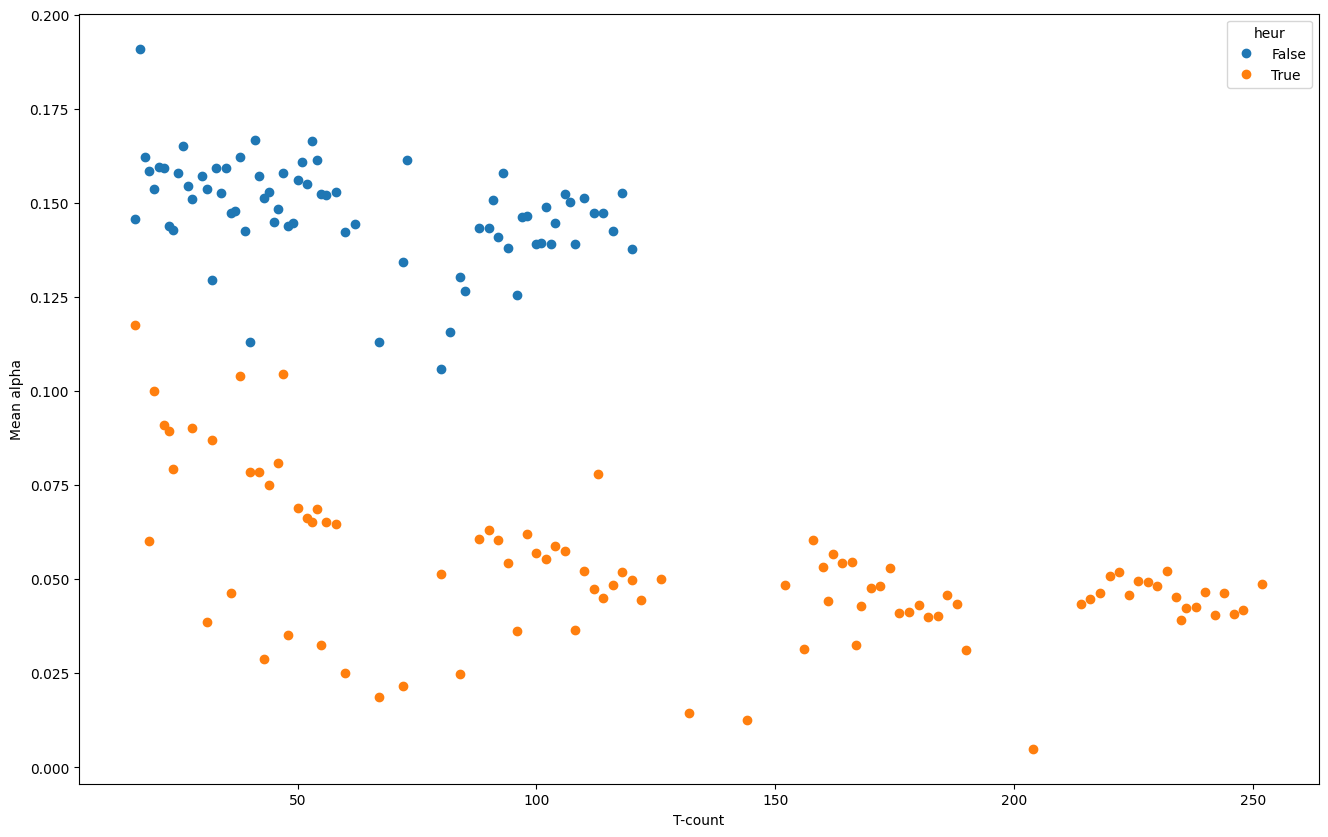

In [515]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Mean alpha",
    marker="o",
    linestyle="None",
    figsize=(16,10)
)

<Axes: xlabel='T-count', ylabel='Median alpha'>

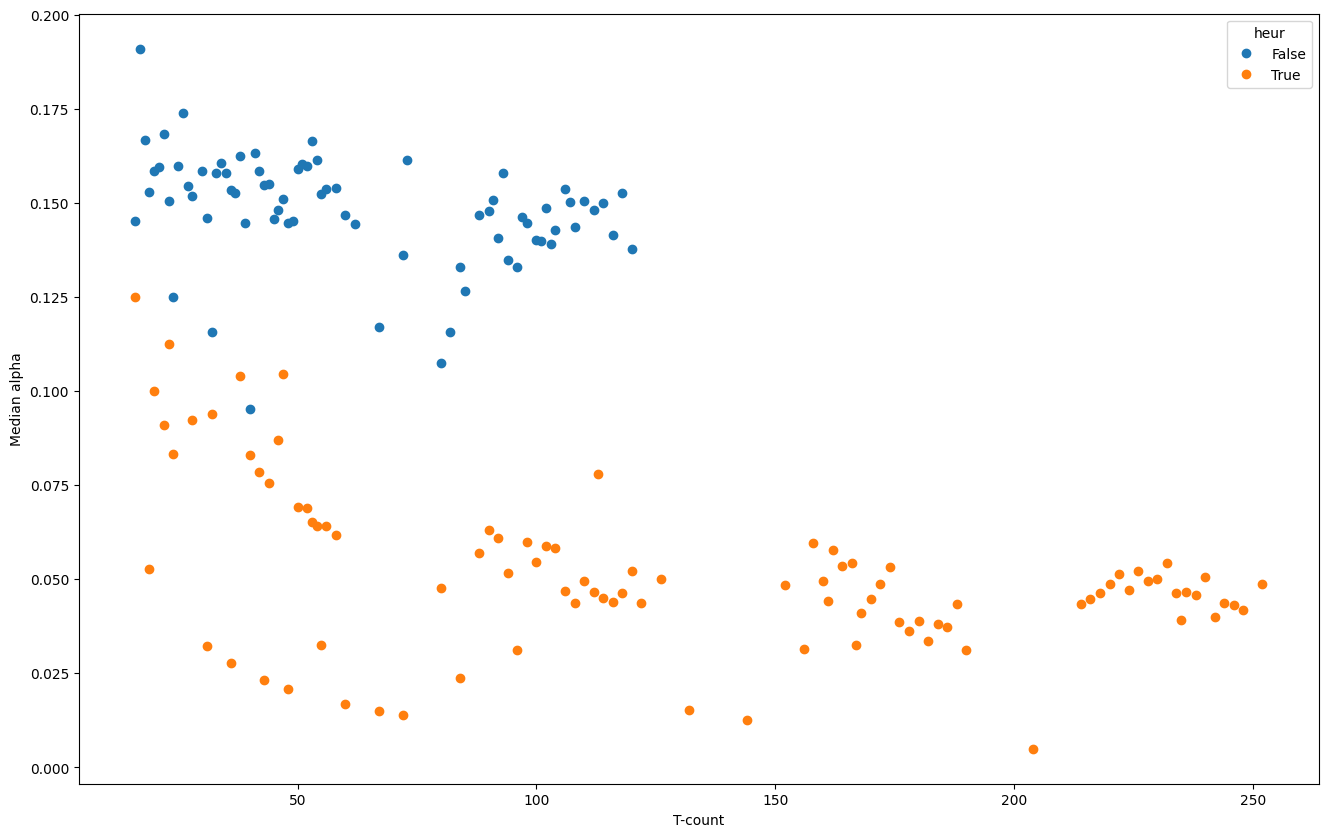

In [516]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).median().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Median alpha",
    marker="o",
    linestyle="None",
    figsize=(16,10)
)

<Axes: xlabel='T-count', ylabel='Mean Log terms'>

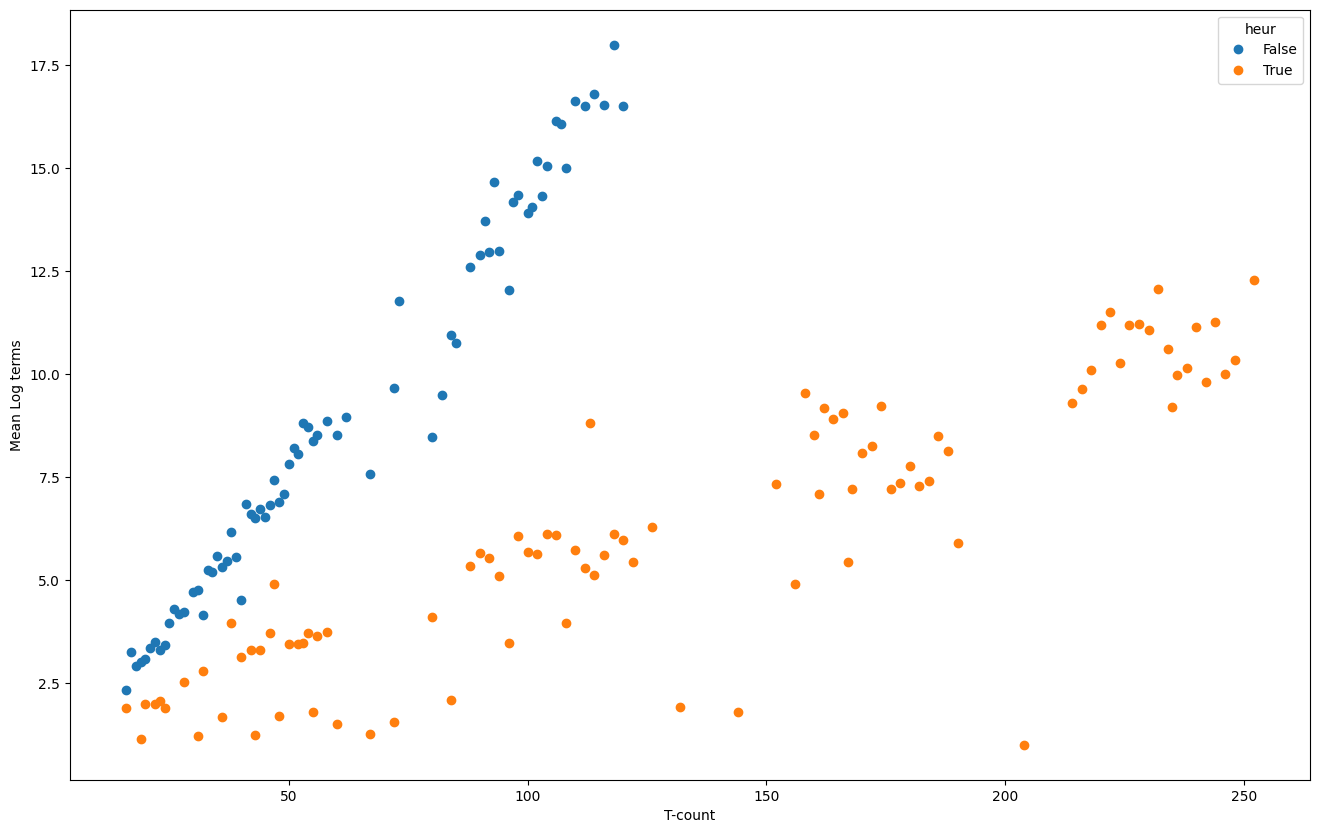

In [517]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["log_terms"].plot(
    xlabel="T-count", 
    ylabel="Mean Log terms",
    marker="o",
    linestyle="None",
    figsize=(16,10)
)

<Axes: xlabel='Number of qubits, T-count', ylabel='Mean Log terms'>

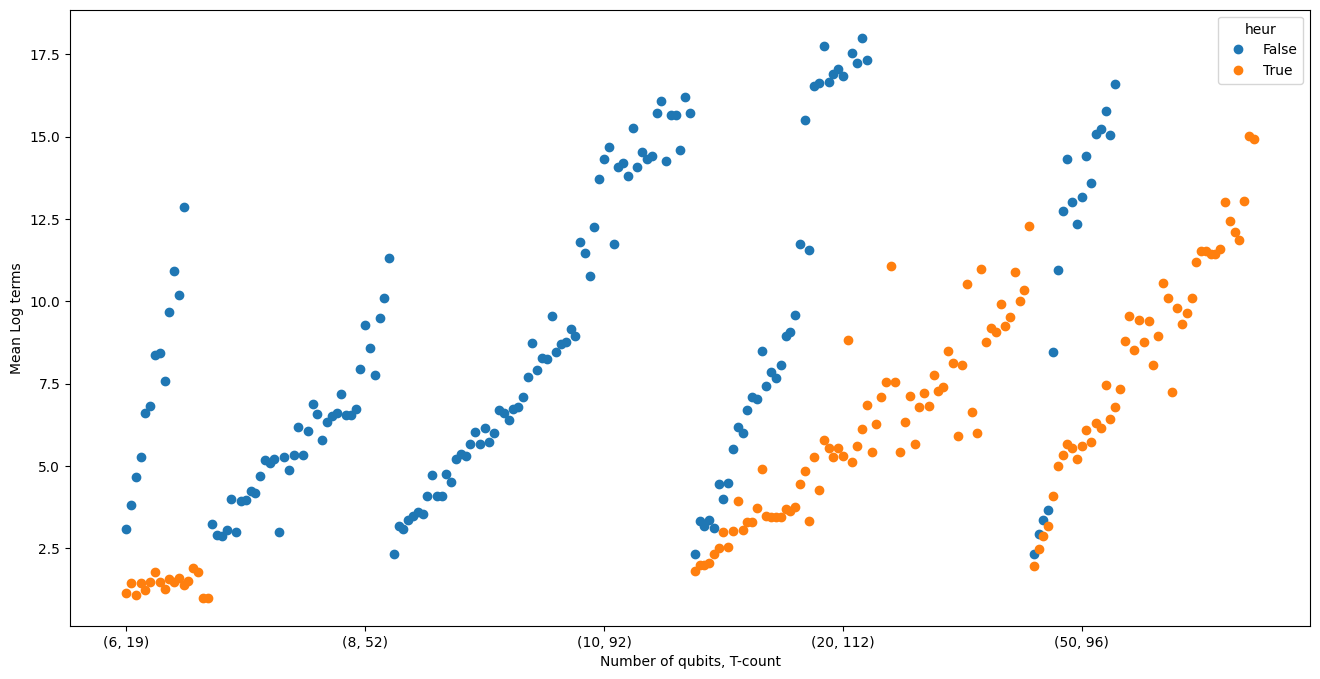

In [518]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby(["qs", groupby_data,feat_name]).mean().unstack()["log_terms"].plot(
    xlabel="Number of qubits, T-count", 
    ylabel="Mean Log terms",
    marker="o",
    linestyle="None",
    figsize=(16,8)
)

<Axes: xlabel='T-count', ylabel='Median Log terms'>

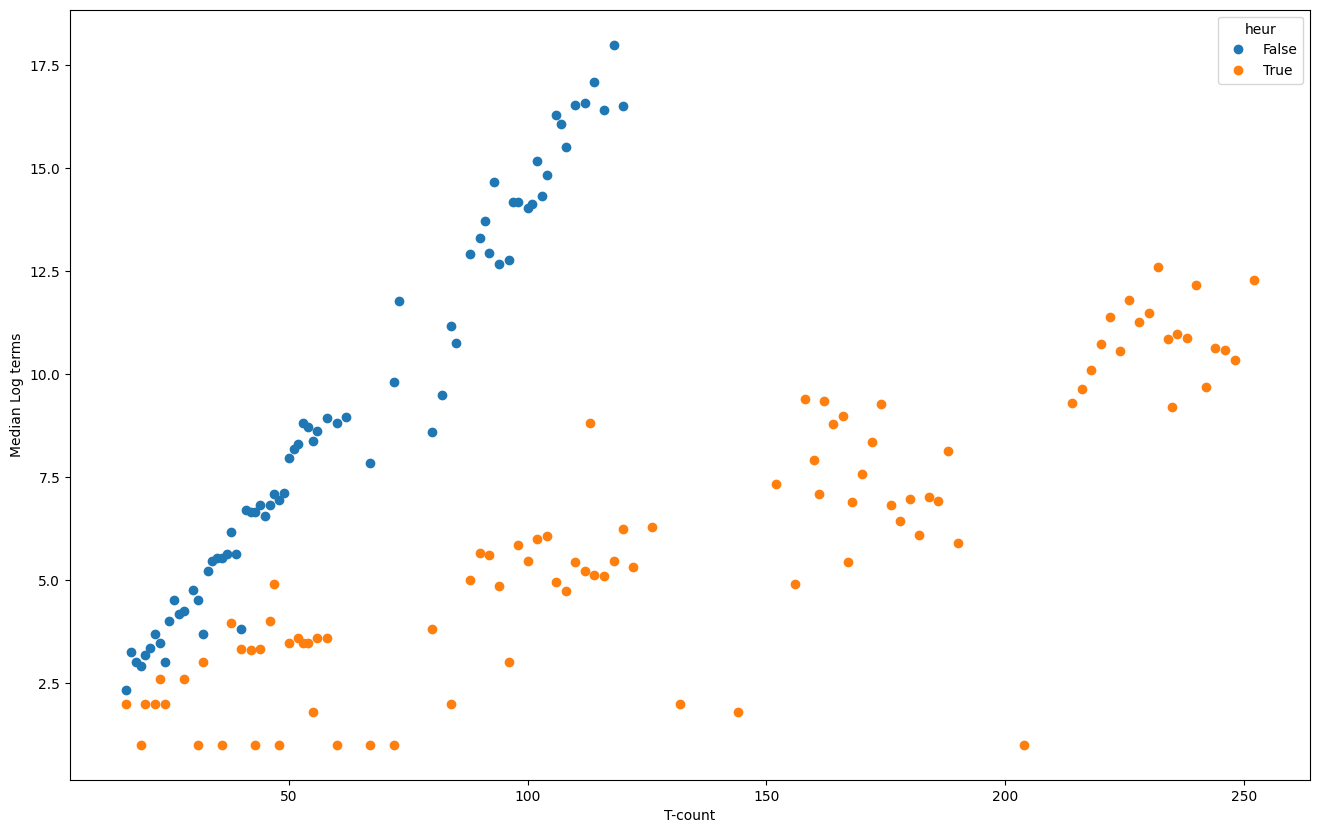

In [519]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).median().unstack()["log_terms"].plot(
    xlabel="T-count", 
    ylabel="Median Log terms",
    marker="o",
    linestyle="None",
    figsize=(16,10)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      qs  depth  seed  terms  time  tcount     alpha   heur  initial_tcount  \
7206   6      4   551      5     3      24  0.096747  False              56   
3250   6      4   551      2     2      24  0.041667   True              56   
6977   6      4  2733     17     5      24  0.170311  False              56   
3041   6      4  2733      2     3      24  0.041667   True              56   
6106   6      4  3988      5     3      24  0.096747  False              56   

      log_terms  log_time      beta  
7206   2.321928  1.584963  0.386988  
3250   1.000000  1.000000  0.166667  
6977   4.087463  2.321928  0.681244  
3041   1.000000  1.584963  0.166667  
6106   2.321928  1.584963  0.386988  


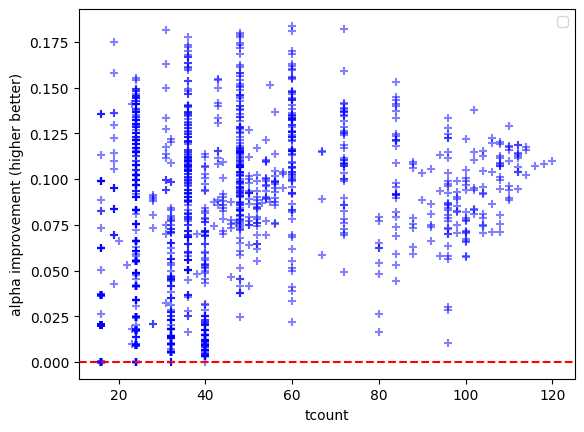

In [520]:
diff_df = data.copy()
if "depth" in diff_df.columns:
    diff_df.sort_values(["qs","depth","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs", "depth","seed"]].duplicated(keep=False)
else:
    diff_df.sort_values(["qs","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs","seed"]].duplicated(keep=False)
single_df = diff_df[~is_paired]
diff_df = diff_df[is_paired]


# diff_df = diff_df.set_index(["qs","seed"])
# diff_df["alpha_diff"] = diff_df.groupby(["qs","seed"], as_index=False)["alpha"].apply(lambda x: x.diff(1))
print(diff_df.head())
# print(len(diff_df[ (diff_df["qs"] == 50)]))
diff_df[f"{efficiency}_diff"] = -diff_df.groupby(diff_df[feat_name].eq(False).cumsum())[efficiency].diff()
# print(diff_df[ ["alpha_diff","alpha"]].head(100))
diff_df = diff_df.dropna()


# Plot the data with translucent points
plt.scatter(diff_df[groupby_data], diff_df[f'{efficiency}_diff'], color='blue', alpha=0.5, marker='+')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel(f'{efficiency} improvement (higher better)')

# Add a legend
plt.legend()

plt.axhline(y=0, color='r', linestyle='--')  # Adds a dashed line at y=0

# Show the plot
plt.show()

In [521]:
single_df.head(100)

,qs,depth,seed,terms,time,tcount,alpha,heur,initial_tcount,log_terms,log_time,beta
236,6,50,3923,4,88,84,0.023810,True,700,2.000000,6.459432,0.333333
1084,6,60,7347,4,106,108,0.018519,True,840,2.000000,6.727920,0.333333
1437,6,70,8722,8,174,96,0.031250,True,980,3.000000,7.442943,0.500000
3275,6,80,1788,6,290,108,0.023935,True,1120,2.584963,8.179909,0.430827
449,6,80,3208,2,108,96,0.010417,True,1120,1.000000,6.754888,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...
4537,8,3,3497,25,6,30,0.154795,False,42,4.643856,2.584963,0.580482
5228,8,3,3741,11,3,27,0.128127,False,42,3.459432,1.584963,0.432429
6610,8,3,4221,13,4,30,0.123348,False,42,3.700440,2.000000,0.462555
3563,8,3,4321,17,4,32,0.127733,False,42,4.087463,2.000000,0.510933


In [522]:
print(len(single_df))

1169


In [523]:
metric = f"{efficiency}_diff"
n1 = 5e-5
n2 = 1e-4

# Define an improvement as a positive value in metric
diff_df['%_improve'] = diff_df[metric] < 0
diff_df[f'%_improve_{n1}'] = diff_df[metric] < -n1
diff_df[f'%_improve_{n2}'] = diff_df[metric] < -n2
diff_df['%_deprove'] = diff_df[metric] > 0
diff_df[f'%_deprove_{n1}'] = diff_df[metric] > n1
diff_df[f'%_deprove_{n2}'] = diff_df[metric] > n2

# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion = diff_df.groupby(groupby_data)['%_improve'].mean()
# Count the number of rows for each max_tcount value
count_df = diff_df[groupby_data].value_counts().reset_index(name='count').rename(columns={'index': groupby_data})
# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion_5 = diff_df.groupby(groupby_data)[f'%_improve_{n1}'].mean()
improvement_proportion_1 = diff_df.groupby(groupby_data)[f'%_improve_{n2}'].mean()
# Count the number of rows for each max_tcount value
# count_df_5 = diff_df[groupby_data].value_counts().reset_index(name='count_5').rename(columns={'index': groupby_data})
# print(count_df_5.head())
# print(count_df.head())
deprovement_proportion = diff_df.groupby(groupby_data)['%_deprove'].mean()
deprovement_proportion_5 = diff_df.groupby(groupby_data)[f'%_deprove_{n1}'].mean()
deprovement_proportion_1 = diff_df.groupby(groupby_data)[f'%_deprove_{n2}'].mean()


prop_df = pd.merge(improvement_proportion, improvement_proportion_5, on=groupby_data)
prop_df = pd.merge(prop_df, improvement_proportion_1, on=groupby_data)

deprop_df = pd.merge(deprovement_proportion, deprovement_proportion_5, on=groupby_data)
deprop_df = pd.merge(deprop_df, deprovement_proportion_1, on=groupby_data)
# pcount_df = pd.merge(count_df, count_df_5, on=groupby_data)

# prop_df = pd.merge(prop_df, deprop_df, on=groupby_data)
prop_df = pd.merge(prop_df, count_df, on=groupby_data)
deprop_df = pd.merge(deprop_df, count_df, on=groupby_data)
print(prop_df.head(20))
print("overall proportion improve: ", diff_df["%_improve"].mean())
print("overall proportion deprove: ", diff_df["%_deprove"].mean())
print(f"overall proportion improve >{n1}: ", diff_df[f'%_improve_{n1}'].mean())
print(f"overall proportion deprove >{n1}: ", diff_df[f"%_deprove_{n1}"].mean())
print(f"overall proportion improve >{n2}: ", diff_df[f'%_improve_{n2}'].mean())
print(f"overall proportion deprove >{n2}: ", diff_df[f"%_deprove_{n2}"].mean())

    tcount  %_improve  %_improve_5e-05  %_improve_0.0001  count
0       16        0.0              0.0               0.0    198
1       19        0.0              0.0               0.0     21
2       20        0.0              0.0               0.0      1
3       22        0.0              0.0               0.0      1
4       23        0.0              0.0               0.0      3
5       24        0.0              0.0               0.0    386
6       28        0.0              0.0               0.0      8
7       31        0.0              0.0               0.0     15
8       32        0.0              0.0               0.0    139
9       36        0.0              0.0               0.0    153
10      38        0.0              0.0               0.0      2
11      40        0.0              0.0               0.0    137
12      42        0.0              0.0               0.0      2
13      43        0.0              0.0               0.0     13
14      44        0.0              0.0  

In [524]:
print(prop_df[prop_df["%_improve"] > 0])

Empty DataFrame
Columns: [tcount, %_improve, %_improve_5e-05, %_improve_0.0001, count]
Index: []


In [525]:
print(deprop_df[deprop_df["%_deprove"] > 0])

    tcount  %_deprove  %_deprove_5e-05  %_deprove_0.0001  count
0       16   0.813131         0.813131          0.813131    198
1       19   1.000000         1.000000          1.000000     21
2       20   1.000000         1.000000          1.000000      1
3       22   1.000000         1.000000          1.000000      1
4       23   1.000000         1.000000          1.000000      3
5       24   0.958549         0.958549          0.958549    386
6       28   1.000000         1.000000          1.000000      8
7       31   1.000000         1.000000          1.000000     15
8       32   0.964029         0.964029          0.964029    139
9       36   1.000000         1.000000          1.000000    153
10      38   1.000000         1.000000          1.000000      2
11      40   0.992701         0.992701          0.992701    137
12      42   1.000000         1.000000          1.000000      2
13      43   1.000000         1.000000          1.000000     13
14      44   1.000000         1.000000  

In [526]:
### Best Improvement and Worst Loss ###
t_df = diff_df.copy()
# t_df = t_df[t_df["alpha_diff"].abs() > 1e-5]
t_df = t_df.groupby([ "qs",groupby_data,"seed",feat_name]).mean().unstack()[f"{efficiency}_diff"]
# print(t_df.head())
t_df.loc[:, "diff"] = t_df[True]
t_df[["diff"]].groupby(["qs",groupby_data]).agg(
    best_improvement=pd.NamedAgg("diff", "max"),
    worst_loss=pd.NamedAgg("diff", "min"),
    avg_diff=pd.NamedAgg("diff", "mean"),
    std_diff=pd.NamedAgg("diff", np.std),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_76238/3703765387.py:7: FutureWarning: The provided callable <function std at 0x105cacea0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  t_df[["diff"]].groupby(["qs",groupby_data]).agg(


best_improvement  worst_loss  avg_diff  std_diff
qs tcount                                                  
6  19              0.174838    0.042492  0.102074  0.031583
   24              0.145494    0.024373  0.098613  0.026072
   31              0.149802    0.069998  0.112786  0.026038
   36              0.172349    0.016249  0.105220  0.030177
   43              0.155008    0.088543  0.126750  0.021650
...                     ...         ...       ...       ...
50 102             0.095107    0.080858  0.087418  0.006687
   104             0.112609    0.070279  0.087611  0.014034
   106             0.086208    0.070834  0.078521  0.010871
   108             0.094543    0.070930  0.080332  0.010224
   110             0.089805    0.088408  0.089106  0.000988

[67 rows x 4 columns]

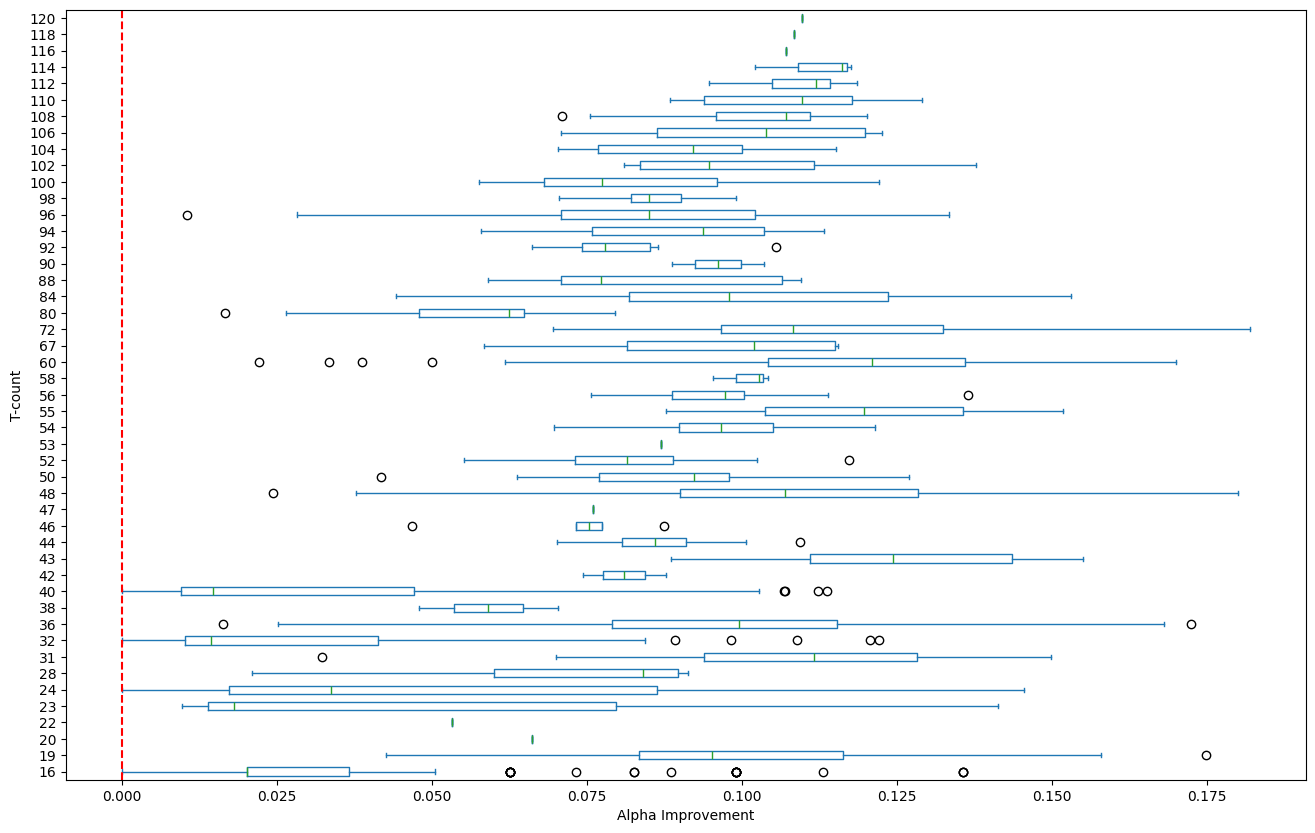

In [527]:
box_df = t_df.groupby(["qs","seed", groupby_data]).mean().unstack()["diff"]
box_df.plot.box(
    xlabel="Alpha Improvement",
    ylabel="T-count",
    vert=False,
    figsize=(16,10),
).axvline(x=0, color='r', linestyle='--')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


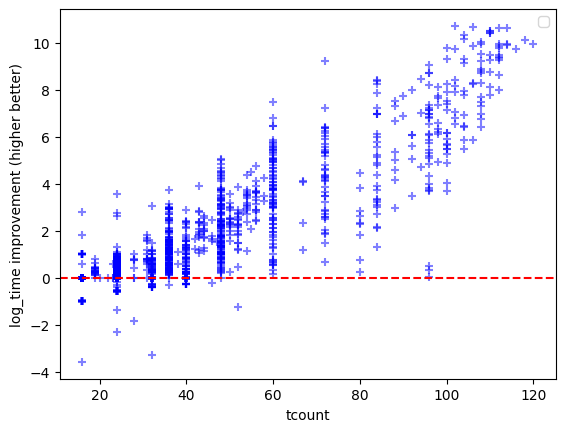

In [528]:
metric = "log_time"
diff_df = data.copy()
# diff_df = diff_df[diff_df["qs"] == 7]
if "depth" in diff_df.columns:
    diff_df.sort_values(["qs","depth","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs", "depth","seed"]].duplicated(keep=False)
else:
    diff_df.sort_values(["qs","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs","seed"]].duplicated(keep=False)
single_df = diff_df[~is_paired]
diff_df = diff_df[is_paired]


# diff_df = diff_df.set_index(["qs","seed"])
# diff_df["alpha_diff"] = diff_df.groupby(["qs","seed"], as_index=False)["alpha"].apply(lambda x: x.diff(1))

# print(len(diff_df[ (diff_df["qs"] == 50)]))
diff_df[f"{metric}_diff"] = -diff_df.groupby(diff_df[feat_name].eq(False).cumsum())[metric].diff()
# print(diff_df[ [f"{metric}_diff",metric]].head(100))
diff_df = diff_df.dropna()


# Plot the data with translucent points
plt.scatter(diff_df[groupby_data], diff_df[f'{metric}_diff'], color='blue', alpha=0.5, marker='+')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel(f'{metric} improvement (higher better)')

# Add a legend
plt.legend()

plt.axhline(y=0, color='r', linestyle='--')  # Adds a dashed line at y=0

# Show the plot
plt.show()

In [529]:
### Best Improvement and Worst Loss ###
t_df = diff_df.copy()
# t_df = t_df[t_df["alpha_diff"].abs() > 1e-5]
t_df = t_df.groupby([groupby_data,"seed",feat_name]).mean().unstack()[f"{metric}_diff"]
t_df.loc[:, "diff"] = t_df[True]
t_df[["diff"]].groupby(groupby_data).agg(
    best_improvement=pd.NamedAgg("diff", "max"),
    worst_loss=pd.NamedAgg("diff", "min"),
    avg_diff=pd.NamedAgg("diff", "mean"),
    std_diff=pd.NamedAgg("diff", np.std),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_76238/2672204182.py:6: FutureWarning: The provided callable <function std at 0x105cacea0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  t_df[["diff"]].groupby(groupby_data).agg(


,best_improvement,worst_loss,avg_diff,std_diff
tcount,,,,
16,1.903677,-2.292481,-0.071926,0.472134
19,0.788496,0.000000,0.311284,0.179426
20,0.000000,0.000000,0.000000,NaN
22,0.000000,0.000000,0.000000,NaN
23,0.584963,0.000000,0.194988,0.337728
24,0.847261,-0.312242,0.197321,0.230725
28,1.000000,-1.847997,0.231041,0.917946
31,1.584963,0.321928,0.912174,0.348959
32,3.044394,-3.285402,0.122477,0.517794


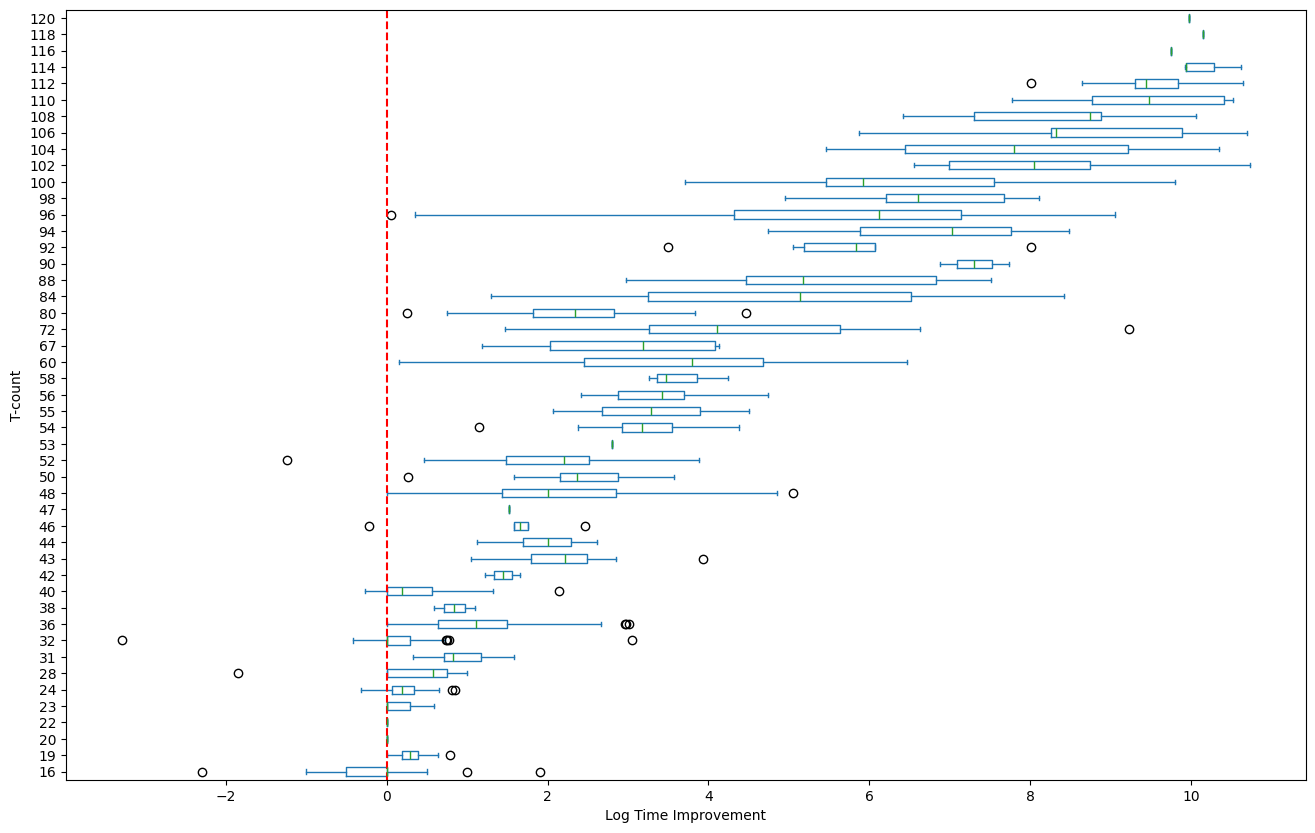

In [530]:
box_df = t_df.groupby(["seed", groupby_data]).mean().unstack()["diff"]
box_df.plot.box(
    xlabel="Log Time Improvement",
    ylabel="T-count",
    vert=False,
    figsize=(16,10),
).axvline(x=0, color='r', linestyle='--')

In [531]:
# metric = "diff"
n1 = 1
n2 = 0.25


# Define an improvement as a positive value in metric
diff_df[f'%_improve_{metric}'] = diff_df[f'{metric}_diff'] < 0
diff_df[f'%_improve_{n1}_{metric}'] = diff_df[f'{metric}_diff'] < -n1
diff_df[f'%_improve_{n2}_{metric}'] = diff_df[f'{metric}_diff'] < -n2
diff_df[f'%_deprove_{metric}'] = diff_df[f'{metric}_diff'] > 0
diff_df[f'%_deprove_{n1}_{metric}'] = diff_df[f'{metric}_diff'] > n1
diff_df[f'%_deprove_{n2}_{metric}'] = diff_df[f'{metric}_diff'] > n2

# print(diff_df[diff_df['red_tcount'] > 40].head(100))

# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion = diff_df.groupby(groupby_data)[f'%_improve_{metric}'].mean()
# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion_5 = diff_df.groupby(groupby_data)[f'%_improve_{n1}_{metric}'].mean()
improvement_proportion_1 = diff_df.groupby(groupby_data)[f'%_improve_{n2}_{metric}'].mean()
# Count the number of rows for each max_tcount value
count_df = diff_df[groupby_data].value_counts().reset_index(name='count').rename(columns={'index': groupby_data})
# Count the number of rows for each max_tcount value
# count_df_5 = diff_df[groupby_data].value_counts().reset_index(name='count_5').rename(columns={'index': groupby_data})
# print(count_df_5.head())
# print(count_df.head())

# print(diff_df.groupby(groupby_data)['%_improve_1_time'].mean().head())
# print(improvement_proportion_5.head())


prop_df = pd.merge(improvement_proportion, improvement_proportion_5, on=groupby_data)
prop_df = pd.merge(prop_df, improvement_proportion_1, on=groupby_data)
# pcount_df = pd.merge(count_df, count_df_5, on=groupby_data)
prop_df = pd.merge(prop_df, count_df, on=groupby_data)
print(prop_df[prop_df[groupby_data] > 40].head(20))
print("overall proportion improve: ", diff_df[f"%_improve_{metric}"].mean())
print("overall proportion deprove: ", diff_df[f"%_deprove_{metric}"].mean())
print(f"overall proportion improve >{n1}: ", diff_df[f'%_improve_{n1}_{metric}'].mean())
print(f"overall proportion deprove >{n1}: ", diff_df[f"%_deprove_{n1}_{metric}"].mean())
print(f"overall proportion improve >{n2}: ", diff_df[f'%_improve_{n2}_{metric}'].mean())
print(f"overall proportion deprove >{n2}: ", diff_df[f"%_deprove_{n2}_{metric}"].mean())

    tcount  %_improve_log_time  %_improve_1_log_time  %_improve_0.25_log_time  \
12      42                0.00                  0.00                     0.00   
13      43                0.00                  0.00                     0.00   
14      44                0.00                  0.00                     0.00   
15      46                0.20                  0.00                     0.00   
16      47                0.00                  0.00                     0.00   
17      48                0.00                  0.00                     0.00   
18      50                0.00                  0.00                     0.00   
19      52                0.05                  0.05                     0.05   
20      53                0.00                  0.00                     0.00   
21      54                0.00                  0.00                     0.00   
22      55                0.00                  0.00                     0.00   
23      56                0.

In [532]:
print(prop_df[prop_df[f'%_improve_{metric}'] > 0])

    tcount  %_improve_log_time  %_improve_1_log_time  %_improve_0.25_log_time  \
0       16            0.186869              0.005051                 0.186869   
5       24            0.129534              0.005181                 0.126943   
6       28            0.125000              0.125000                 0.125000   
8       32            0.093525              0.007194                 0.093525   
9       36            0.006536              0.000000                 0.006536   
11      40            0.065693              0.000000                 0.065693   
15      46            0.200000              0.000000                 0.000000   
19      52            0.050000              0.050000                 0.050000   

    count  
0     198  
5     386  
6       8  
8     139  
9     153  
11    137  
15      5  
19     20  


In [533]:
timeout_df = undropped_data.copy()

# Group by 'qs' and 'depth' and count the number of rows for each unique pair
if "depth" in timeout_df.columns:
    counts = timeout_df.groupby(['qs', 'depth', feat_name]).size().reset_index(name='count')
else:
    counts = timeout_df.groupby(['qs', feat_name]).size().reset_index(name='count')


# Display the result
counts.head()


,qs,depth,heur,count
0,6,1,False,100
1,6,1,True,100
2,6,2,False,100
3,6,2,True,100
4,6,3,False,100


heur   False  True 
depth              
1        500    300
2        500    300
3        500    300
4        500    300
5        500    300


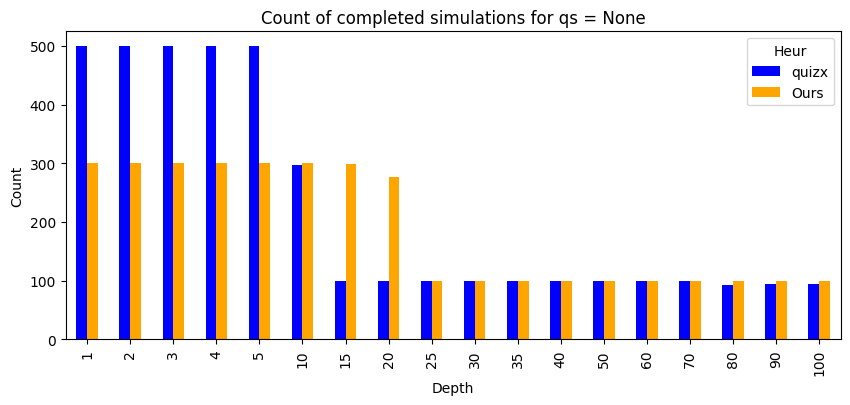

In [534]:
import matplotlib.pyplot as plt


# Filter the DataFrame for a particular value of qs
qs_value = None
filtered_df = timeout_df.copy()
if qs_value is not None:
    filtered_df = timeout_df[timeout_df['qs'] == qs_value]

# Group by 'depth' and 'heur' and count the number of rows
if "depth" in filtered_df.columns:
    heur_counts = filtered_df.groupby(['depth', feat_name]).size().unstack(fill_value=0)
else:
    heur_counts = filtered_df.groupby(['qs', feat_name]).size().unstack(fill_value=0)

print(heur_counts.head())

# Plot the results
heur_counts.plot(kind='bar', stacked=False, figsize=(10, 4), color=['blue', 'orange', 'red'])
plt.xlabel('Depth')
plt.ylabel('Count')
plt.title(f'Count of completed simulations for qs = {qs_value}')
plt.legend(title='Heur', labels=['quizx', 'Ours', 2], bbox_to_anchor=(1, 1))



plt.show()

In [535]:
# # Display the result
# print(counts[counts["qs"] == 20].head(50))

In [536]:
# Display the result
# print(counts[counts["qs"] == 50].head(50))

In [537]:
# Display the result
# print(counts[counts["qs"] == 20].head(50))